In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))
add_to_sys_path(os.path.join('..', '..', '..', 'Scaffolding_OOD'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from XGB import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Import modules for the attack
from config import (
    RANDOM_SEED, N_SAMPLES_DATA, BIAS_CORRELATION_STRENGTH, POSITIVE_OUTCOME,
    TEST_SIZE, LIME_PERTURBATION_STD, LIME_PERTURBATION_MULTIPLIER,
    SHAP_N_SAMPLES_OOD, SHAP_N_KMEANS_BACKGROUND, OOD_PRED_THRESHOLD,
    UNPROTECTED_CLASS_VALUE, PROTECTED_CLASS_VALUE
)
from data_handler import generate_base_data, process_data
from bias_injector import add_highly_correlated_biased_feature
from ood_generator import generate_lime_style_ood, generate_shap_style_ood, combine_ood_data_for_detector_training
from ood_detector import OODDetector
from scaffold_model import Adversarial_Lime_Model, Adversarial_Kernel_SHAP_Model, CombinedAdversarialModel
from explainer_helper import get_lime_explanation, get_shap_explanation, print_explanation, plot_explanation_comparison, get_feature_rank_frequencies, plot_feature_rank_distribution

In [4]:
data = pd.read_csv('../../../Dataset/Fraudulent_online_shops_dataset.csv')
data['Label'] = data['Label'].replace({'fraudulent': 0, 'legitimate': 1})
data['Presence of free contact emails'] = data['Presence of free contact emails'].replace({2: 1, 3: 1})
data['Indication of young domain '] = data['Indication of young domain '].replace({2: 1})
data.head()

,Online shop URL,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,...,SSL certificate expire date,Issuer organization,SSL certificate issuer organization list item,Indication of young domain,Domain registration date,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,https://www.allaccessorybest.com,0,24,3,1,0,27,2,0,1,...,Oct 11 03:53:36 2023 GMT,Google Trust Services LLC,9,1,2023-05-15 03:35,0,NaN,0,0,-1
1,https://www.b-watches.shop,0,18,4,1,0,20,2,1,0,...,Jun 16 23:59:59 2024 GMT,"Cloudflare, Inc.",1,1,2023-06-18 05:43,0,NaN,0,0,-1
2,https://www.waeschenamen-windrath.de,1,28,2,1,0,30,2,1,1,...,Oct 24 21:53:20 2023 GMT,Let's Encrypt,2,1,Hidden,0,-1.0,0,0,-1
3,https://vendoprint.se,1,13,2,0,0,17,1,0,1,...,Oct 9 15:13:00 2023 GMT,Google Trust Services LLC,9,1,2022-09-20 00:00,0,-1.0,0,0,-1
4,https://www.newbikeland.com,0,19,3,1,0,22,2,0,1,...,Oct 25 08:20:27 2023 GMT,Let's Encrypt,2,1,2023-07-27 09:05,0,NaN,0,0,-1


In [5]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,Presence of money back payment,...,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,SSL certificate issuer organization list item,Indication of young domain,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,0,24,3,1,0,27,2,0,1,1,...,0,0,0,9,1,0,NaN,0,0,-1
1,0,18,4,1,0,20,2,1,0,1,...,0,1,0,1,1,0,NaN,0,0,-1
2,1,28,2,1,0,30,2,1,1,0,...,0,1,1,2,1,0,-1.0,0,0,-1
3,1,13,2,0,0,17,1,0,1,0,...,0,1,1,9,1,0,-1.0,0,0,-1
4,0,19,3,1,0,22,2,0,1,1,...,0,0,1,2,1,0,NaN,0,0,-1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Label                                          1140 non-null   int64  
 1   Domain length                                  1140 non-null   int64  
 2   Top domain length                              1140 non-null   int64  
 3   Presence of prefix 'www'                       1140 non-null   int64  
 4   Number  of digits                              1140 non-null   int64  
 5   Number  of letters                             1140 non-null   int64  
 6   Number  of dots (.)                            1140 non-null   int64  
 7   Number  of hyphens (-)                         1140 non-null   int64  
 8   Presence of credit card payment                1140 non-null   int64  
 9   Presence of money back payment                 1140 

In [7]:
len(data)

1140

In [8]:
protected_feature = 'Indication of young domain '

In [9]:
# biased_data = add_highly_correlated_biased_feature(
#         data,
#         target_column='Label',
#         new_feature_name=protected_feature,
#         correlation_strength=BIAS_CORRELATION_STRENGTH,
#         favor_outcome=POSITIVE_OUTCOME # The protected group (value 1) will be favored for POSITIVE_OUTCOME (value 1)
#     )

biased_data = data.copy()

In [10]:
biased_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Label                                          1140 non-null   int64  
 1   Domain length                                  1140 non-null   int64  
 2   Top domain length                              1140 non-null   int64  
 3   Presence of prefix 'www'                       1140 non-null   int64  
 4   Number  of digits                              1140 non-null   int64  
 5   Number  of letters                             1140 non-null   int64  
 6   Number  of dots (.)                            1140 non-null   int64  
 7   Number  of hyphens (-)                         1140 non-null   int64  
 8   Presence of credit card payment                1140 non-null   int64  
 9   Presence of money back payment                 1140 

Injecting deliberatly some synthetic ood data, if want to go witht the original dataset, just comment out the segment

In [11]:
# # Configuration - OOD samples will be 20% of original data size
# ood_ratio = 0.20
# n_ood = int(len(biased_data) * ood_ratio)

# # Identify integer columns (excluding Label)
# int_cols = [col for col in biased_data.columns 
#             if col != 'Label' and biased_data[col].dtype in ['int64', 'int32']]

# # Handle NaN values while preserving integer types
# for col in biased_data.columns:
#     if col == 'Label':
#         continue
#     if col in int_cols:
#         # For integer columns, fill with rounded median to maintain integers
#         biased_data[col] = biased_data[col].fillna(round(biased_data[col].median())).astype(int)
#     else:
#         # For non-integer columns, use mean
#         biased_data[col] = biased_data[col].fillna(biased_data[col].mean())

# X_clean = biased_data.drop(columns='Label').values
# y_clean = biased_data['Label'].values

# # Train KNN on clean data
# knn = KNeighborsClassifier(n_neighbors=3).fit(X_clean, y_clean)

# # Generate LIME-style OOD (50% of OOD samples)
# lime_samples = X_clean[np.random.choice(len(X_clean), size=n_ood//2, replace=True)]
# X_lime, _ = generate_lime_style_ood(lime_samples, feature_names=biased_data.columns.tolist()[1:])
# lime_labels = knn.predict(X_lime)

# # Generate SHAP-style OOD (remaining 50%)
# shap_samples = X_clean[np.random.choice(len(X_clean), size=n_ood//2, replace=True)]
# X_shap, _ = generate_shap_style_ood(shap_samples, feature_names=biased_data.columns.tolist()[1:])
# shap_labels = knn.predict(X_shap)

# # Directly extend biased_data (no new variables created)
# biased_data = pd.concat([
#     biased_data,
#     pd.DataFrame(X_lime, columns=biased_data.columns.tolist()[1:]).assign(Label=lime_labels),
#     pd.DataFrame(X_shap, columns=biased_data.columns.tolist()[1:]).assign(Label=shap_labels)
# ], ignore_index=True)

# # Convert integer columns back to integers (in case generation created floats)
# for col in int_cols:
#     biased_data[col] = biased_data[col].astype(int)

# print(f"Extended dataset size: {len(biased_data)}")
# print("New label distribution:\n", biased_data['Label'].value_counts())

In [12]:
x_train, x_test, y_train, y_test, feature_names = Data_Handler(
        df=biased_data,
        target_column='Label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling numerical features: ['Domain length', 'Top domain length']


In [13]:
print(len(x_train.columns))
x_train.head()

12


,Domain length,Top domain length,Number of digits,Number of hyphens (-),Presence of credit card payment,Presence of cash on delivery payment,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,Presence of SiteJabber reviews,Presence in the standard Tranco list,Indication of young domain
665,-0.319739,-1.147256,0,0,1,0,0,1,1,0,0,0
901,-0.763097,0.175736,1,0,1,1,0,1,1,0,0,0
131,0.788654,0.175736,0,0,0,0,0,0,0,0,0,1
252,-0.098061,0.175736,0,1,0,0,0,1,1,0,0,0
330,1.897047,0.175736,0,0,1,1,0,1,0,0,0,0


In [14]:
feature_names

['Domain length',
 'Top domain length',
 'Number  of digits',
 'Number  of hyphens (-)',
 'Presence of credit card payment',
 'Presence of cash on delivery payment',
 'Presence of crypto currency',
 'Presence of free contact emails',
 'Presence of logo URL',
 'Presence of SiteJabber reviews',
 'Presence in the standard Tranco list',
 'Indication of young domain ']

Accuracy: 0.9035087719298246
Precision: 0.9034727581416886
Recall: 0.9035087719298246
F-1: 0.9034829861478174


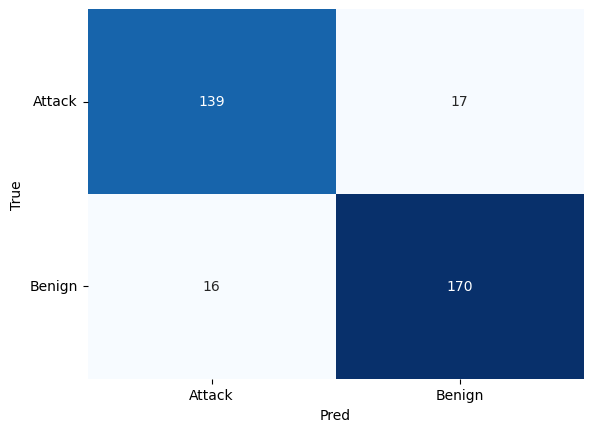

In [15]:
# With the protected feature
f_obscure = base_model_call(x_train, y_train, protected_feature, True)
y_pred_f_obscure = f_obscure.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_f_obscure)

Accuracy: 0.8391812865497076
Precision: 0.8390365892945872
Recall: 0.8391812865497076
F-1: 0.8390438880372454


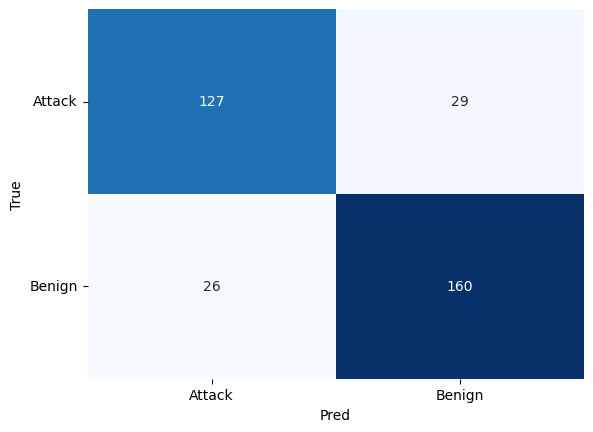

In [16]:
# Without the protected feature
psi_display = base_model_call(x_train, y_train, protected_feature, False)
y_pred_psi_display = psi_display.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_psi_display)

In [17]:
# adv_lime_model = Adversarial_Lime_Model(f_obscure, psi_display, perturbation_std=LIME_PERTURBATION_STD)
# adv_lime_model.train(x_train, feature_names, perturbation_multiplier=LIME_PERTURBATION_MULTIPLIER)
adv_lime_model = CombinedAdversarialModel(f_obscure, psi_display)
adv_lime_model.train(x_train, feature_names)
print(f"Adversarial LIME Model fidelity on test set: {adv_lime_model.fidelity(x_test):.4f}")
print(f"Adversarial LIME Model accuracy on test set: {adv_lime_model.score(x_test, y_test):.4f}")
print(f"Adversarial LIME Model f1 on test set: {adv_lime_model.score_f1(x_test, y_test):.4f}")

--- OOD Generator: Generating LIME-style OOD data ---
Generated 798 LIME-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 1.0000
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       160

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

--- OOD Generator: Generating SHAP-style OOD data ---

Generated 798 SHAP-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.7000
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       0.69      0.72      0.71       160
           1   

In [18]:
adv_lime_model.print_ood_stats(x_test)


=== Combined OOD Detection Report ===
Samples processed: 342
LIME OOD detected: 0 (0.00%)
SHAP OOD detected: 90 (26.32%)
Combined OOD detected: 90 (26.32%)


In [19]:
# adv_shap_model = Adversarial_Kernel_SHAP_Model(f_obscure, psi_display)
# adv_shap_model.train(x_train, feature_names, n_samples=SHAP_N_SAMPLES_OOD, n_kmeans=SHAP_N_KMEANS_BACKGROUND)
adv_shap_model = CombinedAdversarialModel(f_obscure, psi_display)
adv_shap_model.train(x_train, feature_names)
print(f"Adversarial SHAP Model fidelity on test set: {adv_shap_model.fidelity(x_test):.4f}")
print(f"Adversarial SHAP Model accuracy on test set: {adv_shap_model.score(x_test, y_test):.4f}")
print(f"Adversarial SHAP Model f1 on test set: {adv_shap_model.score_f1(x_test, y_test):.4f}")

--- OOD Generator: Generating LIME-style OOD data ---
Generated 798 LIME-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 1.0000
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       160

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

--- OOD Generator: Generating SHAP-style OOD data ---

Generated 798 SHAP-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.7000
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       0.69      0.72      0.71       160
           1   

In [20]:
adv_shap_model.print_ood_stats(x_test)


=== Combined OOD Detection Report ===
Samples processed: 342
LIME OOD detected: 0 (0.00%)
SHAP OOD detected: 90 (26.32%)
Combined OOD detected: 90 (26.32%)


In [21]:
# Select an instance from the test set to explain
instance_to_explain_idx = 1 # Choose the first test instance
instance_to_explain = np.array(x_test.iloc[[instance_to_explain_idx]])
original_prediction = f_obscure.predict(instance_to_explain)
print(f"\nExplaining instance {instance_to_explain_idx} (true label: {y_test.iloc[instance_to_explain_idx]}, f_obscure predicts: {original_prediction})")
x_test.iloc[[instance_to_explain_idx]]



Explaining instance 1 (true label: 1, f_obscure predicts: [1])


,Domain length,Top domain length,Number of digits,Number of hyphens (-),Presence of credit card payment,Presence of cash on delivery payment,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,Presence of SiteJabber reviews,Presence in the standard Tranco list,Indication of young domain
878,0.788654,0.175736,0,0,1,1,0,1,1,0,0,0


In [22]:
# LIME for f_obscure
lime_exp_f_obscure = get_lime_explanation(
        f_obscure,
        instance_to_explain,
        feature_names,
        x_train, # LIME explainer needs training data for background distribution
        class_names=['Benign', 'Malicious']
    )
# print_explanation(lime_exp_f_obscure, feature_names, "LIME Explanation (Original Biased Model)", predicted_class=original_prediction)

In [23]:
shap_background_f_obscure = shap.sample(x_train, 100)
shap_exp_f_obscure = get_shap_explanation(
        f_obscure,
        instance_to_explain.reshape(1, -1), # SHAP expects 2D array
        feature_names,
        shap_background_f_obscure,
        class_names=['Benign', 'Malicious'],
        explainer_type='kernel'
    )
# print_explanation(shap_exp_f_obscure, feature_names, "SHAP Kernel Explanation (Original Biased Model)", predicted_class=original_prediction)

In [24]:
# LIME for Adversarial LIME Model
lime_exp_adv_lime = get_lime_explanation(
        adv_lime_model,
        instance_to_explain,
        feature_names,
        x_train, # LIME explainer needs training data for background distribution
        class_names=['Benign', 'Malicious']
    )
# print_explanation(lime_exp_adv_lime, feature_names, "LIME Explanation (Adversarial LIME Model)", predicted_class=original_prediction)

In [25]:
# SHAP (KernelExplainer) for Adversarial SHAP Model
shap_background_adv_shap = shap.sample(x_train, 100) # Use a sample of training data for background
shap_exp_adv_shap = get_shap_explanation(
        adv_shap_model,
        instance_to_explain.reshape(1, -1), # SHAP expects 2D array
        feature_names,
        shap_background_adv_shap,
        class_names=['Benign', 'Malicious'],
        explainer_type='kernel'
    )
# print_explanation(shap_exp_adv_shap, feature_names, "SHAP Kernel Explanation (Adversarial SHAP Model)", predicted_class=original_prediction)

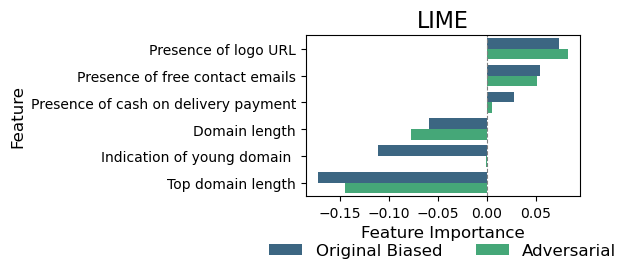

In [26]:
# Plot LIME explanations comparison
plot_explanation_comparison(
        lime_exp_f_obscure,
        lime_exp_adv_lime,
        feature_names,
        protected_feature,
        "LIME",
        predicted_class=original_prediction
    )

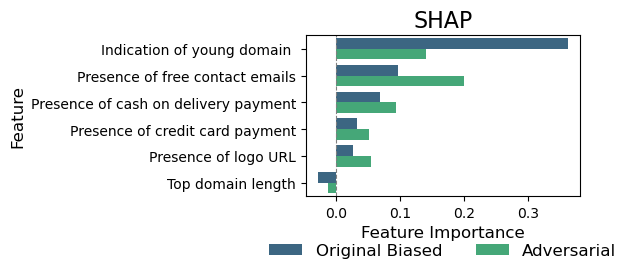

In [27]:
# Plot SHAP explanations comparison
plot_explanation_comparison(
        shap_exp_f_obscure,
        shap_exp_adv_shap,
        feature_names,
        protected_feature,
        "SHAP",
        predicted_class=original_prediction
    )

In [28]:
X_test, X_train = np.array(x_test), np.array(x_train)

In [29]:
def get_categorical_feature_indices(all_feature_names: list, numerical_feature_names: list) -> list:
    """
    Identifies categorical feature names and their indices by excluding numerical features
    from the complete list of feature names.

    Args:
        all_feature_names (list): A list containing all feature names in their original order.
        numerical_feature_names (list): A list containing the names of numerical features.

    Returns:
        list: A sorted list of integer indices corresponding to the categorical features.
    """
    # Convert numerical_feature_names to a set for efficient lookup
    numerical_features_set = set(numerical_feature_names)

    categorical_feature_names = []
    categorical_feature_indices = []

    # Iterate through all feature names to identify categorical ones
    for i, feature_name in enumerate(all_feature_names):
        if feature_name not in numerical_features_set:
            categorical_feature_names.append(feature_name)
            categorical_feature_indices.append(i)

    # Sort the indices to ensure consistent order
    categorical_feature_indices.sort()

    return categorical_feature_indices

In [30]:
# Use a sample of the test data for frequency analysis
num_instances_for_frequency_analysis = min(1000, X_test.shape[0]) # Increased sample size for better statistics
X_freq_sample = X_test[:num_instances_for_frequency_analysis]
# Get predictions for each model on the sample for correct 'predicted_class'
y_pred_freq_sample_f_obscure = f_obscure.predict(X_freq_sample)
y_pred_freq_sample_adv_lime = adv_lime_model.predict(X_freq_sample)
y_pred_freq_sample_adv_shap = adv_shap_model.predict(X_freq_sample)

# SHAP background data for frequency analysis
shap_background_freq = shap.sample(X_train, 100)

top_n_for_rank_plot = 5

lime_categorical_features_indices = get_categorical_feature_indices(x_train.columns, ['Domain length', 'Top domain length', 'SSL certificate issuer organization list item'])

In [31]:
get_categorical_feature_indices(x_train.columns, ['Domain length', 'Top domain length'])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

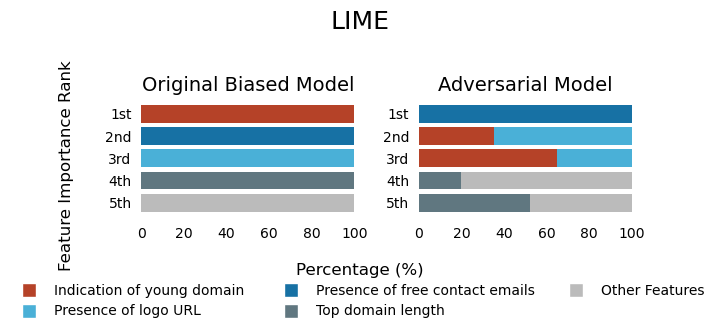

In [32]:
# --- LIME Rank Frequency Analysis ---
lime_rank_freq_data = {}
lime_rank_freq_data['Original Biased Model'] = get_feature_rank_frequencies(
        f_obscure, 'lime', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
        X_train, None, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious'],
        categorical_feature_indices=lime_categorical_features_indices # <--- PASS ALL CATEGORICAL INDICES
    )
lime_rank_freq_data['Adversarial Model'] = get_feature_rank_frequencies(
        adv_lime_model, 'lime', X_freq_sample, feature_names, y_pred_freq_sample_adv_lime,
        X_train, None, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious'],
        categorical_feature_indices=lime_categorical_features_indices # <--- PASS ALL CATEGORICAL INDICES
    )

plot_feature_rank_distribution(
        lime_rank_freq_data, 'LIME', protected_feature,
        "LIME", top_n=top_n_for_rank_plot
    )

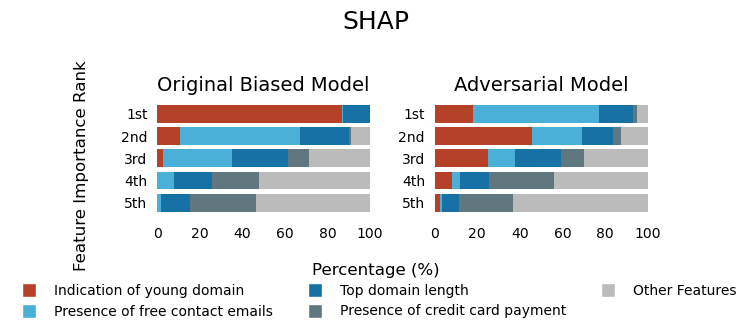

In [33]:
# --- SHAP Rank Frequency Analysis ---
shap_rank_freq_data = {}
shap_rank_freq_data['Original Biased Model'] = get_feature_rank_frequencies(
        f_obscure, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
        None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
    )
shap_rank_freq_data['Adversarial Model'] = get_feature_rank_frequencies(
        adv_shap_model, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_adv_shap,
        None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
    )
# REMOVED: The 'Innocuous (psi)' model is no longer included in the plot data.
# shap_rank_freq_data['Innocuous (psi)'] = get_feature_rank_frequencies(
#         psi_display, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
#         None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
#     )

plot_feature_rank_distribution(
        shap_rank_freq_data, 'SHAP', protected_feature, # Ensure 'protected_feature' is defined in your notebook
        "SHAP", top_n=top_n_for_rank_plot
    )